In [22]:
import os
import os.path
import numpy as np
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import pandas as pd

In [23]:
#Handle data
market_simulator = pd.read_csv(
    '/Users/oscarpeyron/Downloads/012_Quick_Acess/S&P500_index1Y.csv',
    parse_dates=['Datum'],  # Parse 'Datum' as datetime
    index_col='Datum'       # Set 'Datum' as the index
).dropna()


market_simulator["Average_SP_Index"] = (market_simulator["Hoch"] + market_simulator["Tief"]) / 2
market = market_simulator["Average_SP_Index"].iloc[::-1]

# Compute log returns
market_log_returns = np.log(market).diff().dropna()
market_log_returns = (market_log_returns - market_log_returns.mean()) / market_log_returns.std()

print(market_log_returns)


Datum
2020-01-30   -0.589118
2020-01-31   -0.518353
2020-02-03    0.058685
2020-02-04    1.187489
2020-02-05    0.886538
                ...   
2025-01-22    0.900577
2025-01-23    0.083880
2025-01-24    0.139689
2025-01-27   -1.942885
2025-01-28    0.670540
Name: Average_SP_Index, Length: 1256, dtype: float64


AttributeError: module 'matplotlib.pyplot' has no attribute 'vlabel'

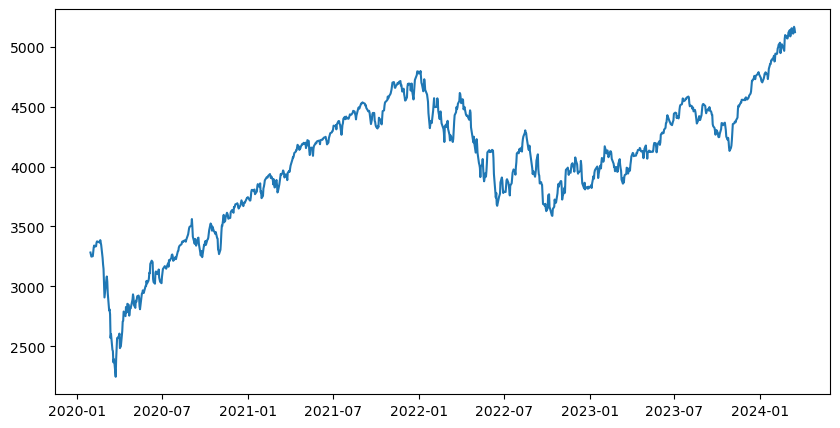

In [24]:
#S&P 500 Market Simulator (Non-stationary market)

t =  0
T = 1040
market_plot = market[t:T]
market_return_plot = market_log_returns[t:T]

# Plot market
plt.figure(figsize=(10, 5))
plt.plot(market_plot.index, market_plot.values, linestyle='-', label=f"Daily Average S&P 500 Index on {T-t} days")
# Formatting
plt.vlabel("Date")
plt.ylabel("Daily Average S&P 500 Index")
plt.title(f"S&P 500 daily Average Over {T-t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

#Plot market returns 
plt.figure(figsize=(10, 5))
plt.plot(market_return_plot.index, market_return_plot.values, linestyle='-', label=f"Daily Average log return S&P 500 Index on {T-t} days")

#Formatting
plt.xlabel("Date")
plt.ylabel("Daily Average S&P 500 Index log return")
plt.title(f"S&P 500 daily Average log return Over {T-t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

plt.show()

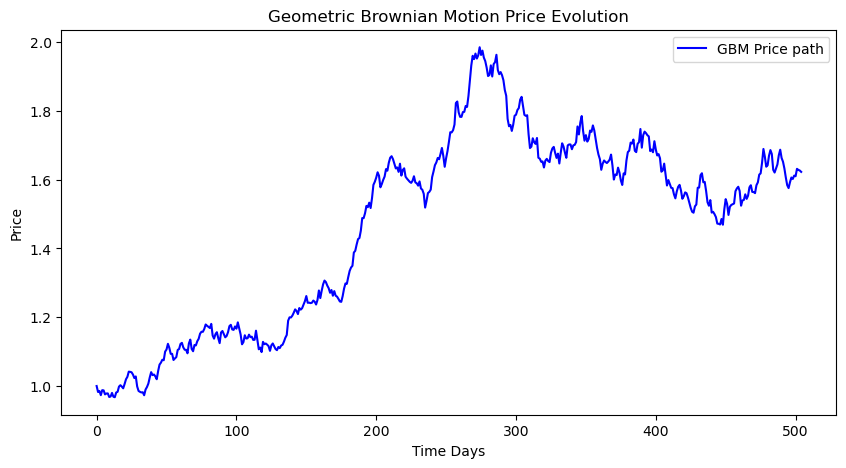

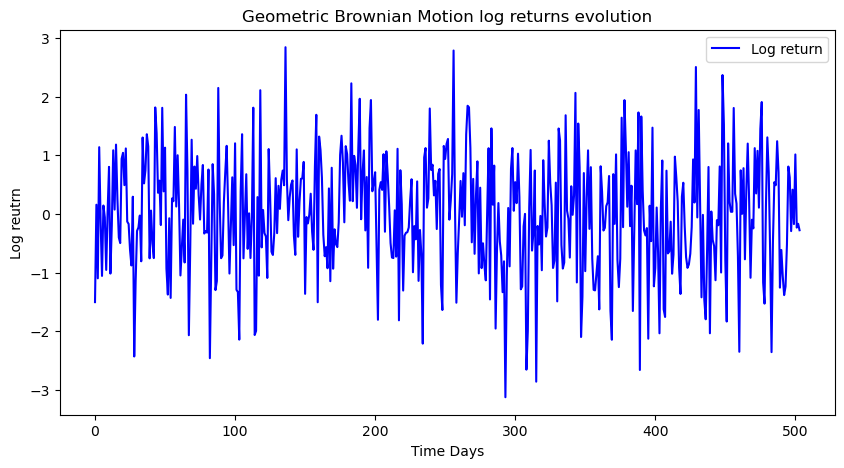

In [30]:
#Market simulation stationary market :

# Parameters
T = 2          # Total years
N = 252 * T    # Number of trading days
dt = 1 / 252   # Time step (daily)
mu = 0.10      # Annual drift (10%)
sigma = 0.20   # Annual volatility (20%)
P0 = 1         # Initial price

# Generate Brownian motion
dW = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments

# Compute the price process using the GBM formula
P = np.zeros(N+1)
P[0] = P0
for t in range(1, N+1):
    P[t] = P[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[t-1])

# Convert to numpy array
P_array = np.array(P)
log_returns = np.diff(np.log(P_array))
market_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

#Plot market 
t = np.arange(len(P_array))
plt.figure(figsize=(10, 5))
plt.plot(t, P_array, linestyle='-', label=f"GBM Price path", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Price")
plt.title("Geometric Brownian Motion Price Evolution")
plt.legend()


# Plot market log returns 
t= np.arange(len(log_returns))
plt.figure(figsize=(10, 5))
plt.plot(t, market_log_returns, linestyle='-', label=f"Log return", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Log reutrn")
plt.title("Geometric Brownian Motion log returns evolution")
plt.legend()




In [32]:
import numpy as np
import random

def emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
):
    # Extract parameters
    alpha, eta_kappa, eta_psi = learning_rates
    v_0 = initial_wealth  
    z = target_payoff
    T, delta_t = investment_horizon, discretization_dt
    lamb = exploration_rate
    M = num_iterations
    N = sample_average_size
    r= interest_rate #yearly interest rate 

    #initialization of parameters (tuning as best as possible)
    psi = [0.05,0.1]
    kappa = [-(v_0 - z)**2, -0.1, -0.05, 2 * psi[1]]

    w= v_0

    psi_policy = psi
   
   #helper lists
    D_final = []
    D_final_pi = []
    D_final_value = []

    #return lists
    pay_off_mean = []
    pay_off_mean_non_agg = []
    variance_off_sample = []
    value_sample = [] #value function
    ratio_risky_asset_sample = []
    ratio_risky_over_time = []
    

    for k in range(1,  M + 1):
        D = [(0, v_0)]  # Collected samples as tuples (time, wealth)
        D_pi = [0] #Collected samples as tuples (time, risky_allocation)
        D_value = [compute_V(kappa, psi, v_0, w, 0, T)]
        print(k)
        for i in range(1, int(T / delta_t)):

            #simulate the market
            t_k, v_k, theta_k = simulate_market(market_simulator,psi_policy, D, w, T, lamb,delta_t,r)

            pi_k = theta_k * np.exp(r*t_k)/v_k

            value_function_k = compute_V(kappa, psi, v_k, w, t_k, T)
            
            #sample collection
            D.append((t_k, v_k))

            #ratio_risky_asset_collection 
            D_pi.append(pi_k)

            #collection of value_function at t_k 
            D_value.append(value_function_k)

            # Compute Bellman error
            delta_t_error = compute_bellman_error(kappa, psi, D, w, T, lamb, delta_t)
            
            #Compute gradientx  
            grad_kappa_1 = compute_grad_kappa_1(kappa, psi, D, w, T, lamb, delta_t)
            grad_kappa_2 = compute_grad_kappa_2(kappa, psi, D, w, T, lamb, delta_t)
            grad_psi_0   = compute_grad_psi_0(kappa, psi, D, w, T, lamb, delta_t)
            grad_psi_1   = compute_grad_psi_1(kappa, psi, D, w, T, lamb, delta_t)

            # Update parameters
            kappa[1] -= eta_kappa * grad_kappa_1
            kappa[2] -= eta_kappa * grad_kappa_2

            # Update kappa[3] and kappa[0] explicitly
            kappa[3] = 2 * psi[1]      # kappa₃ = 2φ₂
            kappa[0] = -kappa[2] * T**2 - kappa[1] * T - (w - z)**2

            #update psi
            psi[0]   -= eta_psi * grad_psi_0
            psi[1]   -= eta_psi * grad_psi_1
        
        #update the policy_psi
        psi_policy[0] = psi[0]
        psi_policy[1] = psi[1]

        #get all the values of x^j_{T/delta} for j in 1 to M 
        D_final.append(D[-1][1]) 

        #get all the values of pi^j_{T/delta}    
        D_final_pi.append(D_pi[-1])

        #get all the values of V_j(T/delta) for j  in 1 to M 
        D_final_value.append(D_value[-1])


        if k == M: 
            ratio_risky_over_time = D_pi
            
        # Update Lagrange multiplier every N iterations (Equation 52)
        if k % N == 0:
            #to plot aggregated mean
            pay_off_mean.append(np.mean([v for v in D_final]))
            recent_samples = D_final[k-N+1:k+1] 
            recent_pi_samples = D_final_pi[k-N+1:k+1]
            recent_value_samples = D_final_value[k-N+1:k+1]

            #compute mean of risky allocations 
            average_terminal_allocation = np.mean([v for v in recent_pi_samples])
        
            #compute mean of value functions 
            average_terminal_value_function = np.mean([v for v in recent_value_samples])

            #compute mean and variance over sample size 
            average_terminal_wealth = np.mean([v for v in recent_samples])
            variance = sum([(v-average_terminal_wealth)**2 for v in recent_samples])

            #append mean of risky allocations
            ratio_risky_asset_sample.append(average_terminal_allocation)

            #append mean of value functions
            value_sample.append(average_terminal_value_function)


            #append mean and variance over sample
            pay_off_mean_non_agg.append(average_terminal_wealth)
            variance_off_sample.append(variance)

            #update of the Lagrange mutiplier omega 
            w -= alpha * (average_terminal_wealth - target_payoff)

    return kappa, psi, w, pay_off_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky_asset_sample, ratio_risky_over_time, value_sample

def policy_psi(psi_policy, v,t, T,w, lamb): #(checked)
    mean = -np.sqrt(2 * psi_policy[1] / (lamb * np.pi))* np.exp((2*psi_policy[0]-1)/2) * ((v - w))  
    variance = (1 / (2 * np.pi)) * np.exp(2 * psi_policy[1]* (T-t) +  (2 * psi_policy[0] - 1))
    return np.random.normal(mean,variance)

def simulate_market(market_simulator, psi_policy, D, w, T, lamb, delta_t,r):
    t_k, v_k = D[-1] #get the last sample
    theta_k = policy_psi(psi_policy, v_k, t_k, T,w,lamb)
    #market return going in 
    dv = market_simulator[int(252*t_k) + 1] #change when going to t_k+1
    
    #one computes the next wealth  
    v_k = v_k + theta_k*(dv*np.exp(-r*t_k) - r*delta_t) 
    t_k  += delta_t
    return t_k, v_k, theta_k 

def compute_bellman_error(kappa, psi, D, w, T, lamb, delta_t): #(checked)
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]  # next time step
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, psi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, psi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = psi[0] + psi[1] * (T - t_i)
        C += (V_dot - lamb * entropy)**2 * delta_t
    return C / 2

def compute_V(kappa, psi, v, w, t, T): #(checked)
    arg = -kappa[3] * (T - t)
    V_gamma = (v - w)**2 * np.exp(arg) + kappa[2] * t**2 + kappa[1] * t + kappa[0]
    return V_gamma

def compute_grad_kappa_1(kappa, psi, D, w, T, lamb, delta_t):
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, psi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, psi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = psi[0] + psi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) *delta_t  
    return C

def compute_grad_kappa_2(kappa, psi, D, w, T, lamb, delta_t):
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, psi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, psi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = psi[0] + psi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) * (t_i_1**2 - t_i**2)
    return C

def compute_grad_psi_0(kappa, psi, D, w, T, lamb, delta_t):
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, psi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, psi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) /delta_t
        entropy = psi[0] + psi[1] * (T - t_i)
        C += (-lamb) * (V_dot - lamb * entropy) * delta_t
    return C

def compute_grad_psi_1(kappa, psi, D, w, T, lamb, delta_t):
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, psi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, psi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t  
        entropy = psi[0] + psi[1] * (T - t_i)
        arg1 = -2 * psi[1] * (T - t_i_1)
        arg2 = -2 * psi[1] * (T - t_i)
        exp_factor_1 = np.exp(arg1)
        exp_factor_2 = np.exp(arg2)
        
        gradient_term = (2 * (v_i_1 - w)**2 * exp_factor_1 * (T - t_i_1) -
                         2 * (v_i - w)**2 * exp_factor_2 * (T - t_i)) / delta_t

        C += (V_dot - lamb * entropy) *  (-gradient_term - lamb * (T - t_i)) * delta_t 
    
    return C


In [33]:
def feasible_target_return(brownian_return, yearly_interest, horizon):
    target = 0.8 * brownian_return *horizon 
    while target < yearly_interest * horizon:
        target = (target + brownian_return *horizon)   
    return target

Brownian expected annual drift 0.1
Brownian standard annual volatility 0.2
Annual interest rate 0.02
Target payoff 1.03
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


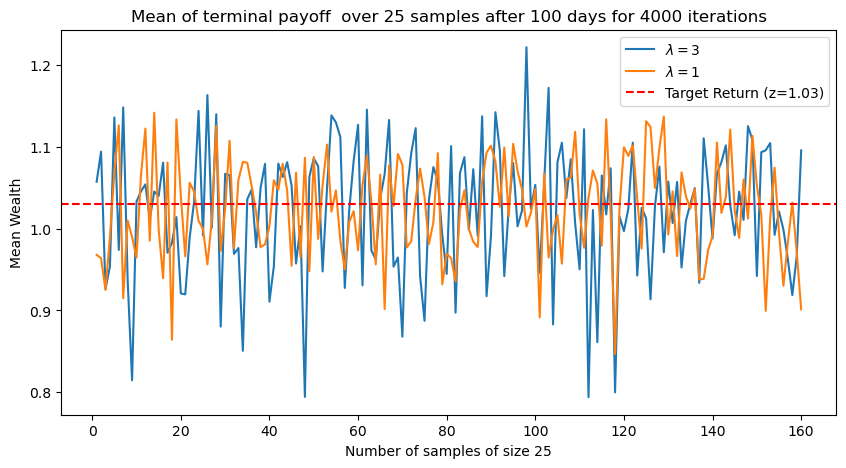

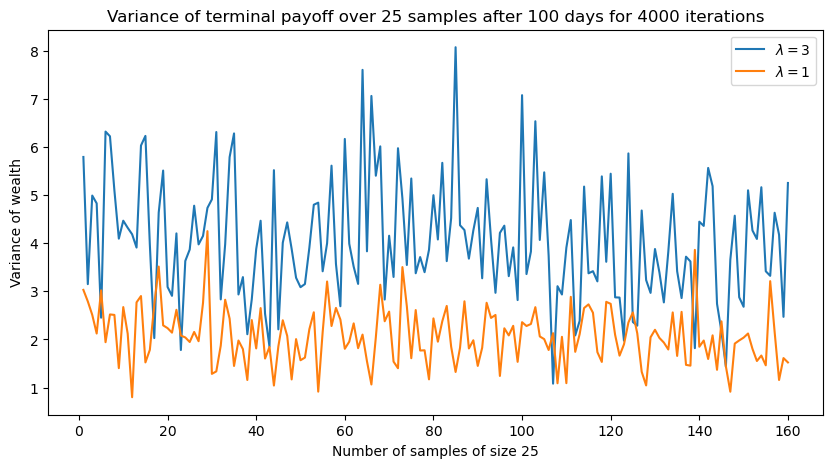

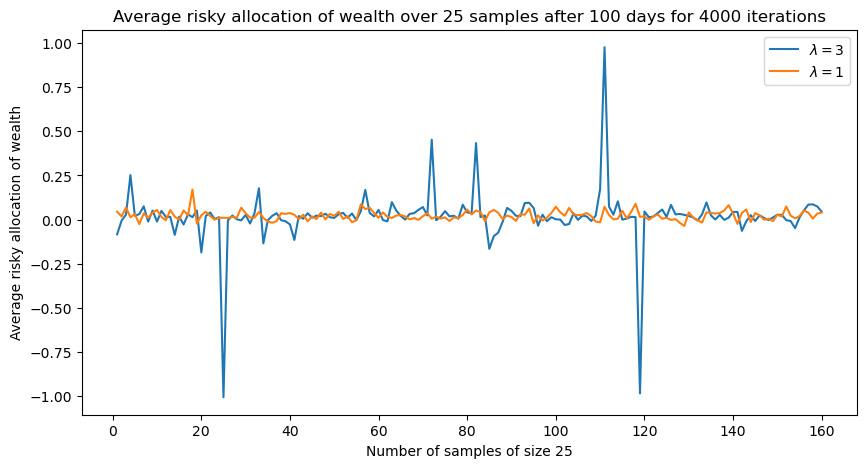

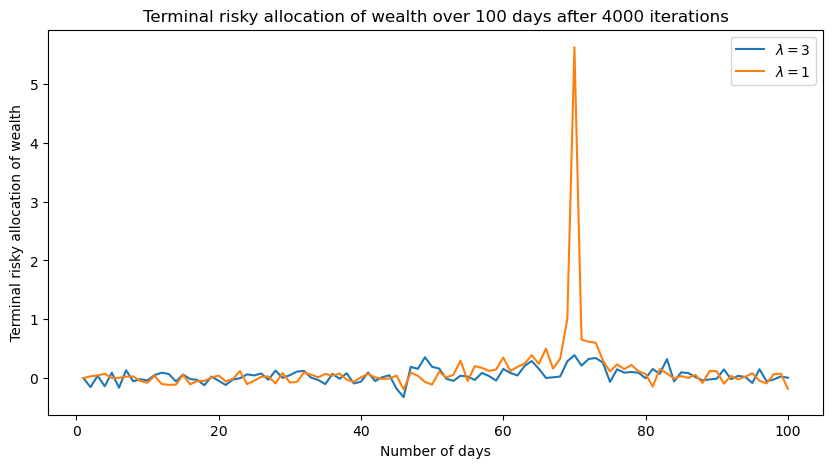

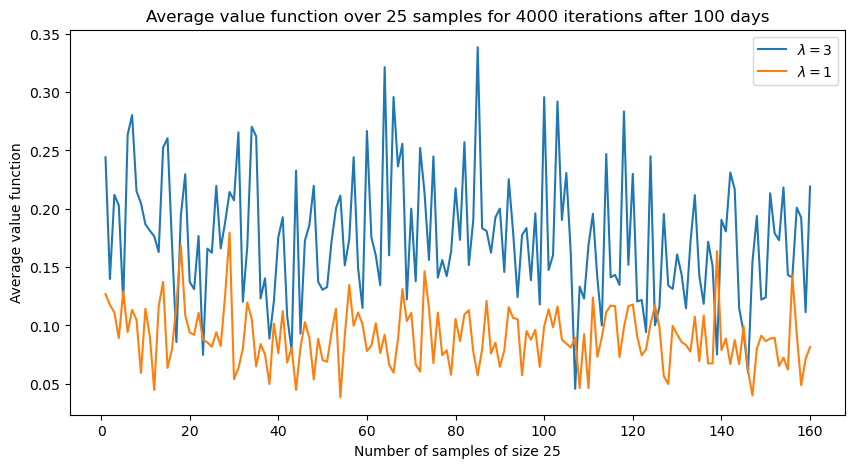

In [35]:
#Market modeled with geomtric Brownian Motion


# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
num_iterations = 4000
sample_average_size = 25

#Market and Target parameters
initial_wealth = 1.0
investment_horizon = 100/252 #T
discretization_dt = 1/252 #number of days #delta_t
interest_rate = 0.02

#print param:
print("Brownian expected annual drift", mu)
print("Brownian standard annual volatility", sigma)
print("Annual interest rate", interest_rate)

#we try to take 80% of the maximum return possible for the number of trading days 
target_payoff = round(1+ feasible_target_return(mu,interest_rate, investment_horizon),2)
print("Target payoff", target_payoff)


market_simulator = market_log_returns #simulate using log returns

exploration_rate_1 = 3 
#calling the function for lambda1 --------------------------------------------------------------
kappa, phi, w, payoff_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate_1, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market modeled with Brownian Motion for lambda", exploration_rate_1)
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)

exploration_rate_2 = 1 #lambda
#calling the function for lambda2 --------------------------------------------------------------
kappa, phi, w, payoff_mean, pay_off_mean_non_agg2, variance_off_sample2, ratio_risky2, ratio_risky_over_time2, value_sample2 = emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate_2, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market modeled with Brownian Motion for lambda", exploration_rate_2)
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#-------------------------------------------- Mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg) + 1))  # X-axis: trajectory indices
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, pay_off_mean_non_agg, linestyle='-', label=rf'$\lambda = {exploration_rate_1}$')
plt.plot(num_trajectories, pay_off_mean_non_agg2, linestyle='-', label=rf'$\lambda = {exploration_rate_2}$')
plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(variance_off_sample) + 1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, variance_off_sample, linestyle='-', label=rf'$\lambda = {exploration_rate_1}$')
plt.plot(num_trajectories, variance_off_sample2, linestyle='-', label=rf'$\lambda = {exploration_rate_2}$')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------mean of risky  allocations  over the sample_average_size------------------------------------------------------------#

num_trajectories = list(range(1,len(ratio_risky) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, ratio_risky, linestyle='-', label=rf'$\lambda = {exploration_rate_1}$')
plt.plot(num_trajectories, ratio_risky2, linestyle='-', label=rf'$\lambda = {exploration_rate_2}$')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Average risky allocation of wealth")
plt.title(f"Average risky allocation of wealth over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()

#--------------------------------------------risky allocations over time ------------------------------------------------------------#



num_trajectories = list(range(1,len(ratio_risky_over_time) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, ratio_risky_over_time, linestyle='-',  label=rf'$\lambda = {exploration_rate_1}$')
plt.plot(num_trajectories, ratio_risky_over_time2, linestyle='-',  label=rf'$\lambda = {exploration_rate_2}$')
plt.xlabel(f"Number of days")
plt.ylabel(f"Terminal risky allocation of wealth")
plt.title(f"Terminal risky allocation of wealth over {int(investment_horizon*1/discretization_dt)} days after {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------value function ------------------------------------------------------------#

num_trajectories = list(range(1,len(value_sample) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, value_sample, linestyle='-', label=rf'$\lambda = {exploration_rate_1}$')
plt.plot(num_trajectories, value_sample2, linestyle='-', label=rf'$\lambda = {exploration_rate_2}$')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Average value function")
plt.title(f"Average value function over {int(sample_average_size)} samples for {num_iterations} iterations after {int(investment_horizon*1/discretization_dt)} days")
plt.legend()
plt.show()










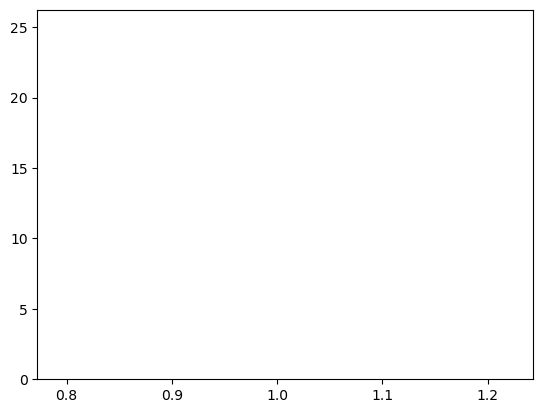

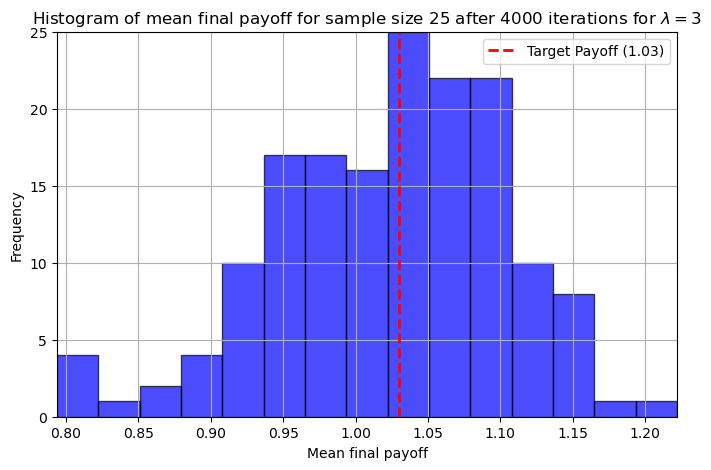

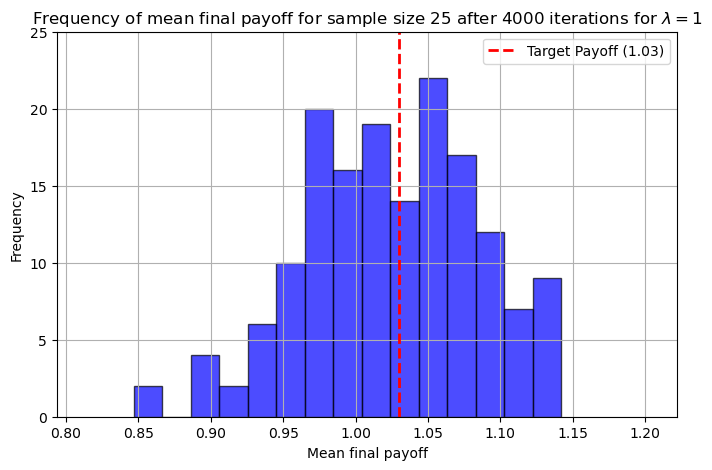

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Compute common x-axis limits
x_min = min(min(pay_off_mean_non_agg), min(pay_off_mean_non_agg2))
x_max = max(max(pay_off_mean_non_agg), max(pay_off_mean_non_agg2))

# Create histograms and get bin counts
counts1, bins1, _ = plt.hist(pay_off_mean_non_agg, bins=15, alpha=0)
counts2, bins2, _ = plt.hist(pay_off_mean_non_agg2, bins=15, alpha=0)

# Compute common y-axis limit (max frequency)
y_max = max(max(counts1), max(counts2))

# Market 1 Plot
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg, bins=15, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

plt.xlabel("Mean final payoff")
plt.ylabel("Frequency")
plt.title(rf'Histogram of mean final payoff for sample size {sample_average_size} after {num_iterations} iterations for $\lambda = {exploration_rate_1}$')
plt.legend()
plt.grid(True)

# Set common axis limits
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)

plt.show()

# Market 2 Plot
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg2, bins=15, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

plt.xlabel("Mean final payoff")
plt.ylabel("Frequency")
plt.title(rf'Frequency of mean final payoff for sample size {sample_average_size} after {num_iterations} iterations for $\lambda = {exploration_rate_2}$')
plt.legend()
plt.grid(True)

# Set common axis limits
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)

plt.show()


In [ ]:
import numpy as np
import random

def emv_portfolio_selection_decreasing_lambda(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
):
    # Extract parameters
    alpha, eta_kappa, eta_phi = learning_rates
    v_0 = initial_wealth  
    z = target_payoff
    T, delta_t = investment_horizon, discretization_dt
    lamb = exploration_rate
    M = num_iterations
    N = sample_average_size
    r= interest_rate #yearly interest rate 

    #initialization of parameters (tuning as best as possible)
    phi = [0.05,0.1]
    kappa = [-(v_0 - z)**2, -0.1, -0.05, 2 * phi[1]]

    w= v_0

    phi_policy = phi
   
   #helper lists
    D_final = []
    D_final_pi = []
    D_final_value = []

    #return lists
    pay_off_mean = []
    pay_off_mean_non_agg = []
    variance_off_sample = []
    value_sample = [] #value function
    ratio_risky_asset_sample = []
    ratio_risky_over_time = []
    

    for k in range(1, M + 1):
        D = [(0, v_0)]  # Collected samples as tuples (time, wealth)
        D_pi = [0] #Collected samples as tuples (time, risky_allocation)
        D_value = [compute_V(kappa, phi, v_0, w, 0, T)]
        #lamb = lamb_0 * np.exp(-100 * k / M) + 0.01
        print(k)
        for i in range(1, int(T / delta_t)):
            #simulate the market
            t_k, v_k, theta_k = simulate_market(market_simulator,phi_policy, D, w, T, lamb,delta_t,r)

            pi_k = theta_k * np.exp(r*t_k)/v_k

            value_function_k = compute_V(kappa, phi, v_k, w, t_k, T)
            
            #sample collection
            D.append((t_k, v_k))

            #ratio_risky_asset_collection 
            D_pi.append(pi_k)

            #collection of value_function at t_k 
            D_value.append(value_function_k)

            # Compute Bellman error
            delta_t_error = compute_bellman_error(kappa, phi, D, w, T, lamb, delta_t)
            
            # Compute gradients (Equations 48-51)
            grad_kappa_1 = compute_grad_kappa_1(kappa, phi, D, w, T, lamb, delta_t)
            grad_kappa_2 = compute_grad_kappa_2(kappa, phi, D, w, T, lamb, delta_t)
            grad_phi_0   = compute_grad_phi_0(kappa, phi, D, w, T, lamb, delta_t)
            grad_phi_1   = compute_grad_phi_1(kappa, phi, D, w, T, lamb, delta_t)

            # Update parameters
            kappa[1] -= eta_kappa * grad_kappa_1
            kappa[2] -= eta_kappa * grad_kappa_2

            # Update kappa[3] and kappa[0] explicitly
            kappa[3] = 2 * phi[1]      # kappa₃ = 2φ₂
            kappa[0] = -kappa[2] * T**2 - kappa[1] * T - (w - z)**2

            #update phi
            phi[0]   -= eta_phi * grad_phi_0
            phi[1]   -= eta_phi * grad_phi_1
        
        #update the policy_phi
        phi_policy[0] = phi[0]
        phi_policy[1] = phi[1]

        #get all the values of x^j_{T/delta} for j in 1 to M 
        D_final.append(D[-1][1]) 

        #get all the values of pi^j_{T/delta}    
        D_final_pi.append(D_pi[-1])

        #get all the values of V_j(T/delta) for j  in 1 to M 
        D_final_value.append(D_value[-1])


        if k == M: 
            ratio_risky_over_time = D_pi
            
        # Update Lagrange multiplier every N iterations (Equation 52)
        if k % N == 0:
            #to plot aggregated mean
            pay_off_mean.append(np.mean([v for v in D_final]))
            recent_samples = D_final[k-N+1:k+1] 
            recent_pi_samples = D_final_pi[k-N+1:k+1]
            recent_value_samples = D_final_value[k-N+1:k+1]

            #compute mean of risky allocations 
            average_terminal_allocation = np.mean([v for v in recent_pi_samples])
        
            #compute mean of value functions 
            average_terminal_value_function = np.mean([v for v in recent_value_samples])

            #compute mean and variance over sample size 
            average_terminal_wealth = np.mean([v for v in recent_samples])
            variance = sum([(v-average_terminal_wealth)**2 for v in recent_samples])

            #append mean of risky allocations
            ratio_risky_asset_sample.append(average_terminal_allocation)

            #append mean of value functions
            value_sample.append(average_terminal_value_function)


            #append mean and variance over sample
            pay_off_mean_non_agg.append(average_terminal_wealth)
            variance_off_sample.append(variance)

            #update of the Lagrange mutiplier omega 
            w -= alpha * (average_terminal_wealth - target_payoff)

    return kappa, phi, w, pay_off_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky_asset_sample, ratio_risky_over_time, value_sample

def policy_phi(phi_policy, v,t, T,w, lamb): #(checked)
    mean = -np.sqrt(2 * phi_policy[1] / (lamb * np.pi))* np.exp((2*phi_policy[0]-1)/2) * ((v - w))  
    variance = (1 / (2 * np.pi)) * np.exp(2 * phi_policy[1]* (T-t) +  (2 * phi_policy[0] - 1))
    return np.random.normal(mean,variance)

def simulate_market(market_simulator, phi_policy, D, w, T, lamb, delta_t,r):
    """Simulates the market and returns sampled (t_k, v_k)."""
    t_k, v_k = D[-1] #get the last sample
    theta_k = policy_phi(phi_policy, v_k, t_k, T,w,lamb)
   
   #market return going in 
    dv = market_simulator[int(252*t_k) + 1] #change when going to t_k+1
    v_k = v_k + theta_k*(dv*np.exp(-r*t_k) - r*delta_t) 
    t_k  += delta_t
    return t_k, v_k, theta_k 

def compute_bellman_error(kappa, phi, D, w, T, lamb, delta_t): #(checked)
    """Computes the Bellman error δ_t (Equation 43)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]  # next time step
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy)**2 * delta_t
    return C / 2

def compute_V(kappa, phi, v, w, t, T): #(checked)
    arg = -kappa[3] * (T - t)
    V_gamma = (v - w)**2 * np.exp(arg) + kappa[2] * t**2 + kappa[1] * t + kappa[0]
    return V_gamma

def compute_grad_kappa_1(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₁ (Equation 48)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) *delta_t  
    return C

def compute_grad_kappa_2(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₂ (Equation 49)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) * (t_i_1**2 - t_i**2)
    return C

def compute_grad_phi_0(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₁ (Equation 50)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) /delta_t
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (-lamb) * (V_dot - lamb * entropy) * delta_t
    return C

def compute_grad_phi_1(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₂ (Equation 51)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        v_i   = D[i][1]
        v_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, v_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, v_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t  
        entropy = phi[0] + phi[1] * (T - t_i)
        arg1 = -2 * phi[1] * (T - t_i_1)
        arg2 = -2 * phi[1] * (T - t_i)
        exp_factor_1 = np.exp(arg1)
        exp_factor_2 = np.exp(arg2)
        
        gradient_term = (2 * (v_i_1 - w)**2 * exp_factor_1 * (T - t_i_1) -
                         2 * (v_i - w)**2 * exp_factor_2 * (T - t_i)) / delta_t

        C += (V_dot - lamb * entropy) *  (-gradient_term - lamb * (T - t_i)) * delta_t 
    
    return C



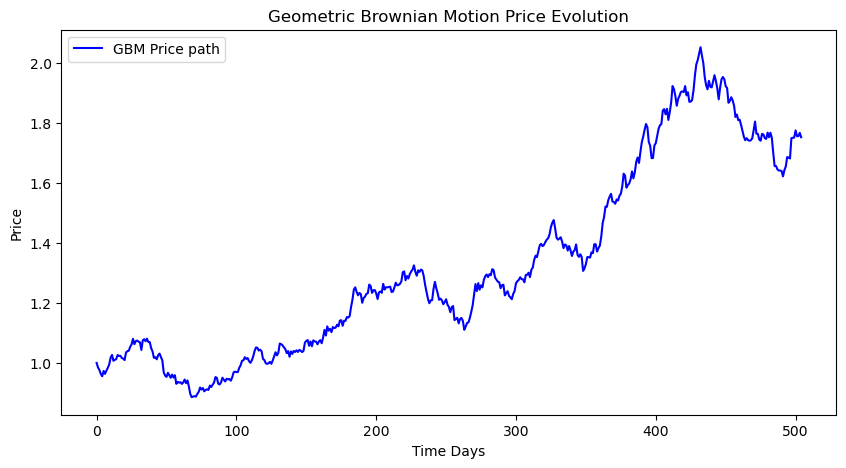

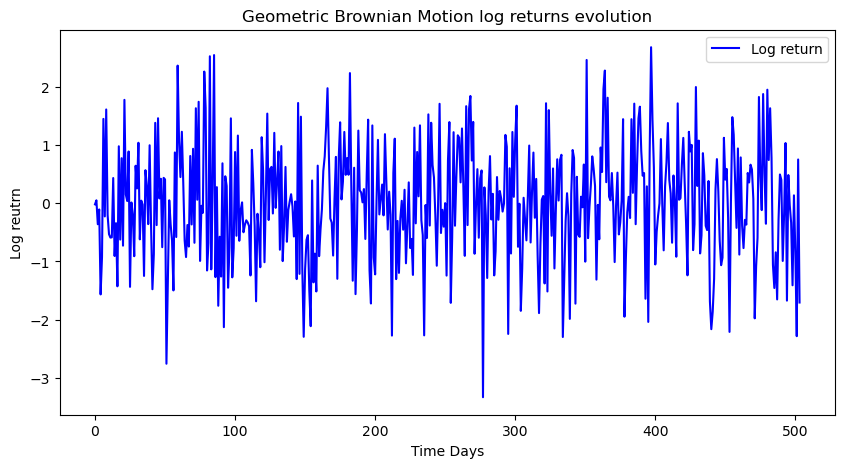

In [16]:
#Market simulation stationary market :

# Parameters
T = 2          # Total years
N = 252 * T    # Number of trading days
dt = 1 / 252   # Time step (daily)
mu = 0.10      # Annual drift (10%)
sigma = 0.20   # Annual volatility (20%)
P02 = 1         # Initial price

# Generate Brownian motion
dW = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments

# Compute the price process using the GBM formula
P2 = np.zeros(N+1)
P2[0] = P02
for t in range(1, N+1):
    P2[t] = P2[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[t-1])

# Convert to numpy array
P_array2 = np.array(P2)
log_returns_2= np.diff(np.log(P_array))
market_log_returns_2 = (log_returns_2 - log_returns_2.mean()) / log_returns_2.std()

#Plot market 
t = np.arange(len(P_array2))
plt.figure(figsize=(10, 5))
plt.plot(t, P_array2, linestyle='-', label=f"GBM Price path", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Price")
plt.title("Geometric Brownian Motion Price Evolution")
plt.legend()


# Plot market log returns 
t= np.arange(len(market_log_returns_2))
plt.figure(figsize=(10, 5))
plt.plot(t, market_log_returns_2, linestyle='-', label=f"Log return", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Log reutrn")
plt.title("Geometric Brownian Motion log returns evolution")
plt.legend()


In [17]:
#Market modeled with geomtric Brownian Motion


print(len(market_simulator))
# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
num_iterations = 4000
sample_average_size = 25

#Market and Target parameters
initial_wealth = 1.0
investment_horizon = 100/252 #T
discretization_dt = 1/252 #number of days #delta_t
interest_rate = 0.02

#print param:
print("Brownian expected annual drift", mu)
print("Brownian standard annual volatility", sigma)
print("Annual interest rate", interest_rate)

#we try to take 80% of the maximum return possible for the number of trading days 
target_payoff = round(1+ feasible_target_return(mu,interest_rate, investment_horizon),2)
print("Target payoff", target_payoff)


market_simulator = market_log_returns_2 #simulate using log returns

exploration_rate_1 = 3 
#calling the function for lambda1 --------------------------------------------------------------
kappa, phi, w, payoff_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky, ratio_risky_over_time, value_sample = emv_portfolio_selection_decreasing_lambda(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate_1, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market modeled with Brownian Motion for lambda", exploration_rate_1)
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#-------------------------------------------- Mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg) + 1))  # X-axis: trajectory indices
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, pay_off_mean_non_agg, linestyle='-', label=rf'$\lambda_0= {exploration_rate_1}$')
plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(variance_off_sample) + 1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, variance_off_sample, linestyle='-', label=rf'$\lambda_0 = {exploration_rate_1}$')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------mean of risky  allocations  over the sample_average_size------------------------------------------------------------#

num_trajectories = list(range(1,len(ratio_risky) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, ratio_risky, linestyle='-', label=rf'$\lambda_0 = {exploration_rate_1}$')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average risky allocation of wealth")
plt.title(f"average risky allocation of wealth over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()

#--------------------------------------------risky allocations over time ------------------------------------------------------------#



num_trajectories = list(range(1,len(ratio_risky_over_time) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, ratio_risky_over_time, linestyle='-',  label=rf'$\lambda_0= {exploration_rate_1}$')
plt.xlabel(f"Number of days")
plt.ylabel(f"Terminal risky allocation of wealth")
plt.title(f"Terminal risky allocation of wealth over {int(investment_horizon*1/discretization_dt)} days after {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------value function ------------------------------------------------------------#

num_trajectories = list(range(1,len(value_sample) +1))
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, value_sample, linestyle='-', label=rf'$\lambda_0 = {exploration_rate_1}$')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average value function")
plt.title(f"average value function over {int(sample_average_size)} samples for {num_iterations} iterations after {int(investment_horizon*1/discretization_dt)} days")
plt.legend()
plt.show()

#--------------------------------------------Histogram ------------------------------------------------------------#

plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg, bins=15, color='blue', alpha=0.7, edgecolor='black')

# Add vertical line for target payoff
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

# Labels and title
plt.xlabel("Mean final payoff")
plt.ylabel("Frequency")
plt.title(rf'Frequency of mean final payoff for sample size {sample_average_size} after {num_iterations} iterations for $\lambda_0 = {exploration_rate_1}$')
plt.legend()
plt.grid(True)
# Show plot
plt.show()








504
Brownian expected annual drift 0.1
Brownian standard annual volatility 0.2
Annual interest rate 0.02
Target payoff 1.03
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


KeyboardInterrupt: 